In [1]:
import pandas as pd 
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import classification_report,  confusion_matrix, accuracy_score, f1_score,  precision_recall_fscore_support

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer   
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPool1D, Conv1D, Input
from tensorflow.keras import layers

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


# Helper Functions

In [2]:
def import_embeddings(path):
    """
    Loads embeddings from a text file
    """
    import os 
    path_to_glove_file = os.path.join(
      os.path.expanduser("~"), path
    )

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    return embeddings_index


### For visualizing trainning loss and validation loss
import matplotlib.pyplot as plt 
def plot_loss(history):
  hist = pd.DataFrame(history.history)
  plt.plot(hist['mae'], label='training_mae')
  plt.plot(hist['val_mae'], label = 'validation_mae')
  plt.legend()
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.show()
  

def make_embedding_matrix(word_index, embedding_dim, embeddings_index):
    """
    Returns embedding matrix
    """
    num_tokens = len(word_index) + 2
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


def compare(X, y_true, y_preds):
  """
  Returns data frame with the test, actual rating, predicited rating, and rounded predicted rating
  """
  return pd.DataFrame({'Text':X, 
                'Actual Rating':y_true, 
                'Predicted Rating':np.squeeze(y_preds),
                'Rounded Rating':np.round(np.squeeze(y_preds))})
  
def get_f1_weighted(compare_df):
  return f1_score(compare_df['Actual Rating'],compare_df['Rounded Rating'], average='weighted')
    


def get_preds(model, X_dev):
  probs = model.predict(X_dev)
  preds = tf.squeeze(tf.round(probs))
  return preds    

def calc_metrics(y_true, y_pred):

 # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
  model_results = {"accuracy": model_accuracy/100,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}

  return model_results



# Loading and Cleaning

In [3]:
la = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Los%20Angeles_restaurant.csv")
sd = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Diego_restaurant.csv")
sf = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Francisco_restaurant.csv")
oc = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Orange%20County_restaurant.csv")
at = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Atalanta_restaurant.csv')
ny = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/New%20York_restaurant.csv')

In [4]:
def clean_name(col):
    if 'http' in col:
        col = col.split('Reviews')[1]
        col = col.split('-')[-2]
        col = col.replace('_',' ')
        return col
    else:
        return col



In [5]:
df = pd.concat([la,sd,ny,oc,sf,at])
df['rating'] = df['rating']/10 
df['restaurant'] = df['restaurant'].apply(lambda x: clean_name(x))
df['restaurant'] = df['restaurant'].apply(lambda x: 'In-N-Out Burger' if 'In N Out' in x else x)
df = df[pd.to_numeric(df['review'], errors='coerce').isnull()]
df = df.dropna(subset=['rating','review'])

# Balance dataset 
- Convert Non 5 ratings to 0 and 5 star ratings to 1

In [6]:
df['is_5'] = df['rating'].apply(lambda x: 1 if x==5 else 0)

In [7]:
df['is_5'].value_counts().values[0]/len(df)
## Percentage of 1 in the dataset

0.5527648291090267

In [8]:
df['is_5'].value_counts()

1    585787
0    473953
Name: is_5, dtype: int64

# Splitting Train Test Dev

In [9]:
def train_dev_test_df(df, splits):
    """"
    Takes in a dataframe and splits into train dev and test
    """
    np.random.seed(42)
    shuffle_df = df.sample(frac=1)

    train, dev = splits

    X = shuffle_df['review'].to_numpy()
    y = shuffle_df['is_5'].to_numpy()

    train_cutoff = int(X.shape[0]*train)
    dev_cutoff = int(X.shape[0]*(train+dev))

    X_train = X[:train_cutoff]
    y_train = y[:train_cutoff]

    X_dev = X[train_cutoff:dev_cutoff]
    y_dev = y[train_cutoff:dev_cutoff]

    X_test = X[dev_cutoff:]
    y_test = y[dev_cutoff:]

    y_train = tf.constant(y_train, dtype=tf.int32)
    y_dev = tf.constant(y_dev, dtype = tf.int32)
    y_test = tf.constant(y_test, dtype=tf.int32)

    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [10]:
train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels = train_dev_test_df(df,(.9,.05))

# Converting to Dataset

In [11]:
# x_train = text_vectorizer(np.array([[s] for s in train_sentences])).numpy()
# x_val = text_vectorizer(np.array([[s] for s in val_sentences])).numpy()

In [12]:
train_data = (tf.data.Dataset.from_tensor_slices(
    (train_sentences,
    train_labels)
))

val_data = (tf.data.Dataset.from_tensor_slices(
    (val_sentences,
    val_labels)
))

In [13]:
batch_size=128
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
train_data_repeat = train_data.repeat()
val_data_repeat = val_data.repeat()

# Models

## Baseline Models: Naives Bayes

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [16]:
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Results

In [17]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 72.96%


In [18]:
baseline_preds = model_0.predict(val_sentences)

baseline_metrics = calc_metrics(val_labels, baseline_preds)
baseline_metrics

{'accuracy': 0.7296317964783815,
 'f1': 0.7776639662290096,
 'precision': 0.7121457604957221,
 'recall': 0.8564591665812054}

In [19]:
print(classification_report(val_labels, baseline_preds))

              precision    recall  f1-score   support

           0       0.76      0.57      0.66     23734
           1       0.71      0.86      0.78     29253

    accuracy                           0.73     52987
   macro avg       0.74      0.71      0.72     52987
weighted avg       0.74      0.73      0.72     52987



## Deep Models 
---
 - Need to find the Avg and St dev for the amount of words per review

### No pretrain embeddings 

In [20]:
train_sentences_lengths = pd.Series([len(i.split()) for i in train_sentences])

max_length = int(train_sentences_lengths.mean() + train_sentences_lengths.std())
max_vocab_length = 70000

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_sentences)

In [ ]:
!pip install wandb

In [66]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [81]:
def train():
  hyperparamters_defaults = dict(epochs=5,
                                batch_size=batch_size,
                                optimizer='adam',
                                loss_function='binary_crossentropy',
                                architecture='LSTM',
                                embed_dim = 256,
                                max_vocab_length=max_vocab_length,
                                 learning_rate=0.001)

  run = wandb.init(project='food_nlp_sweep_5',
                  config = hyperparamters_defaults)

  config = wandb.config

  embedding = Embedding(input_dim=config.max_vocab_length,
                        output_dim=config.embed_dim,
                        embeddings_initializer='uniform',
                        input_length = max_length)

  inputs = Input(shape=(1,), dtype='string')

  x = text_vectorizer(inputs)

  x = embedding(x)
  x = Bidirectional(LSTM(config.lstm_units, return_sequences=True))(x) 
  x = Dropout(0.4)(x)
  x = Bidirectional(LSTM(config.lstm_units))(x) 
  x = Dropout(0.4)(x)
  
  x = Dense(config.dense_units, activation='relu')(x)

  outputs = Dense(1, activation="sigmoid")(x)

  model_1 = tf.keras.Model(inputs, outputs, name="model_1_LSTM")
  model_1.summary()

  METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')] 

  model_1.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=METRICS)
  
  model_1.fit(train_data_repeat,    ## repeat data set required when the steps per epoch does not equal the total number of batches
            epochs=config.epochs,
            steps_per_epoch=int(0.2*len(train_data)),
            validation_data = val_data_repeat,
            validation_steps = int(0.2*len(val_data)),
            callbacks=[WandbCallback(save_weights_only=True)])

  model_1.fit(train_data,steps_per_epoch=len(train_data))
 
  model_1_preds = get_preds(model_1, val_data)
  model_1_metrics = calc_metrics(val_labels, model_1_preds)

  wandb.log(model_1_metrics)

  

In [82]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'dense_units': {
            'values': [8,16,32,64,128,256]
        },
         'lstm_units': {
            'values' : [8,16,32,64,128,256]
        }
    }
}

In [83]:
sweep_id = wandb.sweep(sweep_config, project='food_nlp_sweep_5')        

Create sweep with ID: rcv8o7pp
Sweep URL: https://wandb.ai/jacobh0830/food_nlp_sweep_5/sweeps/rcv8o7pp


#### Training

In [84]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: 884g8a92 with config:
wandb: 	dense_units: 8
wandb: 	lstm_units: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 16)            16960     
_________________________________________________________________
dropout (Dropout)            (None, 60, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 164s 110ms/step - loss: 0.5014 - accuracy: 0.7520 - precision: 0.7524 - recall: 0.8211 - val_loss: 0.4796 - val_accuracy: 0.7651 - val_precision: 0.7738 - val_recall: 0.8113
Epoch 3/5
1490/1490 [==============================] - 164s 110ms/step - loss: 0.4872 - accuracy: 0.7610 - precision: 0.7589 - recall: 0.8338 - val_loss: 0.4765 - val_accuracy: 0.7676 - val_precision: 0.7595 - val_recall: 0.8468
Epoch 4/5
1490/1490 [==============================] - 164s 110ms/step - loss: 0.4792 - accuracy: 0.7644 - precision: 0.7630 - recall: 0.8302 - val_loss: 0.4679 - val_accuracy: 0.7725 - val_precision: 0.7792 - val_recall: 0.8196
Epoch 5/5
7452/7452 [==============================] - 790s 106ms/step - loss: 0.4376 - accuracy: 0.7914 - precision: 0.7878 - recall: 0.8524


epoch,4
loss,0.47277
accuracy,0.7737
precision,0.77244
recall,0.83653
val_loss,0.46355
val_accuracy,0.77391
val_precision,0.76137
val_recall,0.85936
_runtime,1626
_timestamp,1626375311


epoch,▁▃▅▆█
loss,█▄▂▂▁
accuracy,▁▅▆▇▇█
precision,▁▅▆▇▇█
recall,▁▄▇▆██
val_loss,█▄▄▂▁
val_accuracy,▁▅▆██
val_precision,▁▇▃█▄
val_recall,▃▁▆▂█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 0d3lsj7x with config:
wandb: 	dense_units: 8
wandb: 	lstm_units: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 32)            34944     
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 155s 104ms/step - loss: 0.4967 - accuracy: 0.7541 - precision: 0.7532 - recall: 0.8250 - val_loss: 0.4817 - val_accuracy: 0.7629 - val_precision: 0.7938 - val_recall: 0.7700
Epoch 3/5
1490/1490 [==============================] - 154s 103ms/step - loss: 0.4838 - accuracy: 0.7629 - precision: 0.7595 - recall: 0.8371 - val_loss: 0.4760 - val_accuracy: 0.7682 - val_precision: 0.7636 - val_recall: 0.8397
Epoch 4/5
1490/1490 [==============================] - 154s 103ms/step - loss: 0.4763 - accuracy: 0.7665 - precision: 0.7632 - recall: 0.8354 - val_loss: 0.4747 - val_accuracy: 0.7636 - val_precision: 0.7321 - val_recall: 0.9012
Epoch 5/5
7452/7452 [==============================] - 764s 102ms/step - loss: 0.4336 - accuracy: 0.7930 - precision: 0.7890 - recall: 0.8540


epoch,4
loss,0.46871
accuracy,0.77342
precision,0.7682
recall,0.84436
val_loss,0.46112
val_accuracy,0.7762
val_precision,0.76671
val_recall,0.85401
_runtime,1552
_timestamp,1626376867


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▅▆▇██
recall,▁▄▆▆▇█
val_loss,█▅▄▃▁
val_accuracy,▁▄▆▄█
val_precision,▂█▅▁▅
val_recall,▆▁▅█▅
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: p0xdt20t with config:
wandb: 	dense_units: 8
wandb: 	lstm_units: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 64)            73984     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 150s 100ms/step - loss: 0.4961 - accuracy: 0.7539 - precision: 0.7533 - recall: 0.8245 - val_loss: 0.4783 - val_accuracy: 0.7632 - val_precision: 0.7870 - val_recall: 0.7825
Epoch 3/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4821 - accuracy: 0.7625 - precision: 0.7608 - recall: 0.8335 - val_loss: 0.4741 - val_accuracy: 0.7671 - val_precision: 0.7740 - val_recall: 0.8160
Epoch 4/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4740 - accuracy: 0.7678 - precision: 0.7655 - recall: 0.8342 - val_loss: 0.4646 - val_accuracy: 0.7731 - val_precision: 0.7747 - val_recall: 0.8298
Epoch 5/5
7452/7452 [==============================] - 730s 98ms/step - loss: 0.4325 - accuracy: 0.7928 - precision: 0.7885 - recall: 0.8544


epoch,4
loss,0.46664
accuracy,0.77645
precision,0.76701
recall,0.85472
val_loss,0.46046
val_accuracy,0.7762
val_precision,0.7601
val_recall,0.86818
_runtime,1495
_timestamp,1626378367


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇▇█
precision,▁▅▆▇██
recall,▁▄▅▅▆█
val_loss,█▄▃▂▁
val_accuracy,▁▄▅▇█
val_precision,▁█▆▆▃
val_recall,▅▁▄▅█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: arw0cx0h with config:
wandb: 	dense_units: 8
wandb: 	lstm_units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           164352    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 147s 99ms/step - loss: 0.4952 - accuracy: 0.7542 - precision: 0.7548 - recall: 0.8221 - val_loss: 0.4859 - val_accuracy: 0.7629 - val_precision: 0.7703 - val_recall: 0.8122
Epoch 3/5
1490/1490 [==============================] - 147s 99ms/step - loss: 0.4815 - accuracy: 0.7627 - precision: 0.7602 - recall: 0.8354 - val_loss: 0.4779 - val_accuracy: 0.7690 - val_precision: 0.7594 - val_recall: 0.8506
Epoch 4/5
1490/1490 [==============================] - 146s 98ms/step - loss: 0.4734 - accuracy: 0.7674 - precision: 0.7669 - recall: 0.8303 - val_loss: 0.4662 - val_accuracy: 0.7727 - val_precision: 0.7654 - val_recall: 0.8476
Epoch 5/5
7452/7452 [==============================] - 723s 97ms/step - loss: 0.4332 - accuracy: 0.7917 - precision: 0.7887 - recall: 0.8512


epoch,4
loss,0.46664
accuracy,0.77449
precision,0.76563
recall,0.85249
val_loss,0.46016
val_accuracy,0.77668
val_precision,0.76789
val_recall,0.8528
_runtime,1471
_timestamp,1626379841


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▅▆██▇
recall,▁▃▅▄▆█
val_loss,█▆▄▂▁
val_accuracy,▁▄▅▇█
val_precision,▁█▁▅▆
val_recall,▁▁█▇█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 2bbyoxss with config:
wandb: 	dense_units: 8
wandb: 	lstm_units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 147s 99ms/step - loss: 0.4952 - accuracy: 0.7544 - precision: 0.7569 - recall: 0.8182 - val_loss: 0.4767 - val_accuracy: 0.7676 - val_precision: 0.7701 - val_recall: 0.8248
Epoch 3/5
1490/1490 [==============================] - 148s 99ms/step - loss: 0.4818 - accuracy: 0.7619 - precision: 0.7637 - recall: 0.8258 - val_loss: 0.4819 - val_accuracy: 0.7725 - val_precision: 0.7663 - val_recall: 0.8452
Epoch 4/5
1490/1490 [==============================] - 148s 99ms/step - loss: 0.4739 - accuracy: 0.7667 - precision: 0.7681 - recall: 0.8260 - val_loss: 0.4649 - val_accuracy: 0.7706 - val_precision: 0.7677 - val_recall: 0.8372
Epoch 5/5
7452/7452 [==============================] - 733s 98ms/step - loss: 0.4339 - accuracy: 0.7911 - precision: 0.7878 - recall: 0.8516


epoch,4
loss,0.46576
accuracy,0.77659
precision,0.75945
recall,0.8713
val_loss,0.46038
val_accuracy,0.77182
val_precision,0.7678
val_recall,0.84036
_runtime,1488
_timestamp,1626381334


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▆▇█
precision,▁▅▇▇█▆
recall,▁▂▃▃▄█
val_loss,█▄▅▂▁
val_accuracy,▁▆█▇█
val_precision,▁█▇▇▇
val_recall,█▁▆▄▅
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: k838m5tl with config:
wandb: 	dense_units: 8
wandb: 	lstm_units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 512)           1050624   
_________________________________________________________________
dropout (Dropout)            (None, 60, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 161s 108ms/step - loss: 0.4978 - accuracy: 0.7541 - precision: 0.7527 - recall: 0.8266 - val_loss: 0.4757 - val_accuracy: 0.7687 - val_precision: 0.7711 - val_recall: 0.8255
Epoch 3/5
1490/1490 [==============================] - 161s 108ms/step - loss: 0.4836 - accuracy: 0.7613 - precision: 0.7555 - recall: 0.8416 - val_loss: 0.4784 - val_accuracy: 0.7701 - val_precision: 0.7581 - val_recall: 0.8564
Epoch 4/5
1490/1490 [==============================] - 161s 108ms/step - loss: 0.4743 - accuracy: 0.7666 - precision: 0.7621 - recall: 0.8383 - val_loss: 0.4678 - val_accuracy: 0.7678 - val_precision: 0.7934 - val_recall: 0.7828
Epoch 5/5
7452/7452 [==============================] - 800s 107ms/step - loss: 0.4351 - accuracy: 0.7907 - precision: 0.7846 - recall: 0.8566


epoch,4
loss,0.467
accuracy,0.777
precision,0.76176
recall,0.86733
val_loss,0.46309
val_accuracy,0.77468
val_precision,0.75232
val_recall,0.88165
_runtime,1625
_timestamp,1626382963


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▆▇█
precision,▁▅▆▇█▇
recall,▁▃▅▅▅█
val_loss,█▃▄▂▁
val_accuracy,▁▆▇▆█
val_precision,▁▅▄█▃
val_recall,▆▄▆▁█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 5bu6wai6 with config:
wandb: 	dense_units: 16
wandb: 	lstm_units: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 16)            16960     
_________________________________________________________________
dropout (Dropout)            (None, 60, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 145s 98ms/step - loss: 0.5015 - accuracy: 0.7526 - precision: 0.7546 - recall: 0.8182 - val_loss: 0.4823 - val_accuracy: 0.7641 - val_precision: 0.7829 - val_recall: 0.7918
Epoch 3/5
1490/1490 [==============================] - 145s 98ms/step - loss: 0.4870 - accuracy: 0.7608 - precision: 0.7613 - recall: 0.8279 - val_loss: 0.4746 - val_accuracy: 0.7681 - val_precision: 0.7815 - val_recall: 0.8044
Epoch 4/5
1490/1490 [==============================] - 146s 98ms/step - loss: 0.4778 - accuracy: 0.7664 - precision: 0.7641 - recall: 0.8335 - val_loss: 0.4733 - val_accuracy: 0.7704 - val_precision: 0.7773 - val_recall: 0.8179
Epoch 5/5
7452/7452 [==============================] - 722s 97ms/step - loss: 0.4352 - accuracy: 0.7931 - precision: 0.7894 - recall: 0.8533


epoch,4
loss,0.4715
accuracy,0.76962
precision,0.78395
recall,0.8044
val_loss,0.46221
val_accuracy,0.77553
val_precision,0.76829
val_recall,0.849
_runtime,1477
_timestamp,1626384445


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▄▅▆▆█
recall,▂▄▆▇█▁
val_loss,█▅▃▃▁
val_accuracy,▁▄▆▆█
val_precision,▁██▆▃
val_recall,▃▁▃▄█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: yanuf5qy with config:
wandb: 	dense_units: 16
wandb: 	lstm_units: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 32)            34944     
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 145s 97ms/step - loss: 0.4964 - accuracy: 0.7539 - precision: 0.7530 - recall: 0.8250 - val_loss: 0.4819 - val_accuracy: 0.7634 - val_precision: 0.7695 - val_recall: 0.8151
Epoch 3/5
1490/1490 [==============================] - 145s 97ms/step - loss: 0.4826 - accuracy: 0.7620 - precision: 0.7591 - recall: 0.8356 - val_loss: 0.4735 - val_accuracy: 0.7679 - val_precision: 0.7613 - val_recall: 0.8436
Epoch 4/5
1490/1490 [==============================] - 145s 97ms/step - loss: 0.4749 - accuracy: 0.7668 - precision: 0.7633 - recall: 0.8360 - val_loss: 0.4745 - val_accuracy: 0.7628 - val_precision: 0.7988 - val_recall: 0.7616
Epoch 5/5
7452/7452 [==============================] - 721s 97ms/step - loss: 0.4325 - accuracy: 0.7937 - precision: 0.7897 - recall: 0.8544


epoch,4
loss,0.46817
accuracy,0.7736
precision,0.77672
recall,0.82792
val_loss,0.46064
val_accuracy,0.77639
val_precision,0.77462
val_recall,0.83846
_runtime,1476
_timestamp,1626385925


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▄▅▆▇█
recall,▁▄▇▇█▅
val_loss,█▅▃▄▁
val_accuracy,▁▄▆▄█
val_precision,▁▄▃█▅
val_recall,▇▆█▁█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: mf40i0c9 with config:
wandb: 	dense_units: 16
wandb: 	lstm_units: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 64)            73984     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 157s 105ms/step - loss: 0.4941 - accuracy: 0.7561 - precision: 0.7563 - recall: 0.8239 - val_loss: 0.4759 - val_accuracy: 0.7668 - val_precision: 0.7800 - val_recall: 0.8037
Epoch 3/5
1490/1490 [==============================] - 156s 105ms/step - loss: 0.4813 - accuracy: 0.7629 - precision: 0.7611 - recall: 0.8339 - val_loss: 0.4776 - val_accuracy: 0.7707 - val_precision: 0.7674 - val_recall: 0.8381
Epoch 4/5
1490/1490 [==============================] - 156s 105ms/step - loss: 0.4738 - accuracy: 0.7667 - precision: 0.7656 - recall: 0.8309 - val_loss: 0.4655 - val_accuracy: 0.7732 - val_precision: 0.7764 - val_recall: 0.8267
Epoch 5/5
7452/7452 [==============================] - 788s 106ms/step - loss: 0.4326 - accuracy: 0.7928 - precision: 0.7890 - recall: 0.8535


epoch,4
loss,0.46649
accuracy,0.77587
precision,0.75884
recall,0.87075
val_loss,0.4611
val_accuracy,0.77487
val_precision,0.75188
val_recall,0.88321
_runtime,1587
_timestamp,1626387515


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇▇█
precision,▁▅▆▇█▆
recall,▁▃▄▄▄█
val_loss,█▄▄▂▁
val_accuracy,▁▆▇██
val_precision,▁█▆▇▄
val_recall,▆▁▄▃█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: gok8zrfp with config:
wandb: 	dense_units: 16
wandb: 	lstm_units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           164352    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 158s 106ms/step - loss: 0.4955 - accuracy: 0.7543 - precision: 0.7542 - recall: 0.8240 - val_loss: 0.4799 - val_accuracy: 0.7655 - val_precision: 0.7861 - val_recall: 0.7897
Epoch 3/5
1490/1490 [==============================] - 159s 107ms/step - loss: 0.4819 - accuracy: 0.7627 - precision: 0.7623 - recall: 0.8309 - val_loss: 0.4702 - val_accuracy: 0.7718 - val_precision: 0.7691 - val_recall: 0.8378
Epoch 4/5
1490/1490 [==============================] - 158s 106ms/step - loss: 0.4731 - accuracy: 0.7677 - precision: 0.7664 - recall: 0.8321 - val_loss: 0.4702 - val_accuracy: 0.7711 - val_precision: 0.7918 - val_recall: 0.7935
Epoch 5/5
7452/7452 [==============================] - 787s 106ms/step - loss: 0.4328 - accuracy: 0.7925 - precision: 0.7889 - recall: 0.8529


epoch,4
loss,0.46628
accuracy,0.77868
precision,0.77496
recall,0.84429
val_loss,0.46136
val_accuracy,0.77506
val_precision,0.76061
val_recall,0.86403
_runtime,1594
_timestamp,1626389114


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▄▆▆▇█
precision,▁▅▆▇▇█
recall,▁▄▅▆▇█
val_loss,█▄▂▂▁
val_accuracy,▁▆▇▇█
val_precision,▁▇▅█▄
val_recall,█▁▆▁█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: xped07dc with config:
wandb: 	dense_units: 16
wandb: 	lstm_units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 157s 106ms/step - loss: 0.5004 - accuracy: 0.7527 - precision: 0.7532 - recall: 0.8215 - val_loss: 0.4801 - val_accuracy: 0.7635 - val_precision: 0.7664 - val_recall: 0.8217
Epoch 3/5
1490/1490 [==============================] - 157s 106ms/step - loss: 0.4847 - accuracy: 0.7621 - precision: 0.7600 - recall: 0.8342 - val_loss: 0.4784 - val_accuracy: 0.7680 - val_precision: 0.7572 - val_recall: 0.8528
Epoch 4/5
1490/1490 [==============================] - 157s 105ms/step - loss: 0.4754 - accuracy: 0.7657 - precision: 0.7655 - recall: 0.8289 - val_loss: 0.4724 - val_accuracy: 0.7693 - val_precision: 0.7665 - val_recall: 0.8366
Epoch 5/5
7452/7452 [==============================] - 782s 105ms/step - loss: 0.4372 - accuracy: 0.7895 - precision: 0.7862 - recall: 0.8504


epoch,4
loss,0.46774
accuracy,0.77398
precision,0.76242
recall,0.85796
val_loss,0.46156
val_accuracy,0.77096
val_precision,0.7729
val_recall,0.82792
_runtime,1584
_timestamp,1626390702


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▅▆▇█▇
recall,▁▃▅▄▆█
val_loss,█▄▄▃▁
val_accuracy,▁▅▇▇█
val_precision,▁▆▄▆█
val_recall,▅▁█▄▂
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 0f387pxx with config:
wandb: 	dense_units: 16
wandb: 	lstm_units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 512)           1050624   
_________________________________________________________________
dropout (Dropout)            (None, 60, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 166s 112ms/step - loss: 0.4981 - accuracy: 0.7529 - precision: 0.7533 - recall: 0.8220 - val_loss: 0.4805 - val_accuracy: 0.7651 - val_precision: 0.7600 - val_recall: 0.8388
Epoch 3/5
1490/1490 [==============================] - 167s 112ms/step - loss: 0.4838 - accuracy: 0.7613 - precision: 0.7599 - recall: 0.8323 - val_loss: 0.4734 - val_accuracy: 0.7723 - val_precision: 0.7605 - val_recall: 0.8569
Epoch 4/5
1490/1490 [==============================] - 167s 112ms/step - loss: 0.4738 - accuracy: 0.7665 - precision: 0.7662 - recall: 0.8293 - val_loss: 0.4744 - val_accuracy: 0.7593 - val_precision: 0.8121 - val_recall: 0.7332
Epoch 5/5
7452/7452 [==============================] - 827s 111ms/step - loss: 0.4357 - accuracy: 0.7904 - precision: 0.7867 - recall: 0.8518


epoch,4
loss,0.46607
accuracy,0.77566
precision,0.75608
recall,0.87639
val_loss,0.46015
val_accuracy,0.77449
val_precision,0.78599
val_recall,0.8122
_runtime,1679
_timestamp,1626392386


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▅▆▇█▅
recall,▁▃▄▄▅█
val_loss,█▄▃▃▁
val_accuracy,▁▆█▅█
val_precision,▂▁▁█▄
val_recall,▃▇█▁▅
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: y0t7t78l with config:
wandb: 	dense_units: 32
wandb: 	lstm_units: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 16)            16960     
_________________________________________________________________
dropout (Dropout)            (None, 60, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 158s 106ms/step - loss: 0.5004 - accuracy: 0.7526 - precision: 0.7544 - recall: 0.8189 - val_loss: 0.4843 - val_accuracy: 0.7651 - val_precision: 0.7684 - val_recall: 0.8215
Epoch 3/5
1490/1490 [==============================] - 158s 106ms/step - loss: 0.4864 - accuracy: 0.7607 - precision: 0.7610 - recall: 0.8280 - val_loss: 0.4781 - val_accuracy: 0.7695 - val_precision: 0.7696 - val_recall: 0.8309
Epoch 4/5
1490/1490 [==============================] - 158s 106ms/step - loss: 0.4785 - accuracy: 0.7648 - precision: 0.7649 - recall: 0.8277 - val_loss: 0.4781 - val_accuracy: 0.7702 - val_precision: 0.7727 - val_recall: 0.8264
Epoch 5/5
7452/7452 [==============================] - 790s 106ms/step - loss: 0.4375 - accuracy: 0.7909 - precision: 0.7888 - recall: 0.8492


epoch,4
loss,0.47241
accuracy,0.77355
precision,0.77459
recall,0.83191
val_loss,0.47282
val_accuracy,0.77287
val_precision,0.76225
val_recall,0.8547
_runtime,1595
_timestamp,1626393986


epoch,▁▃▅▆█
loss,█▄▂▂▁
accuracy,▁▅▆▇▇█
precision,▁▅▆▆▇█
recall,▁▅▇▇█▇
val_loss,█▄▃▃▁
val_accuracy,▁▅▇▇█
val_precision,▁▆▇█▄
val_recall,▁▂▄▃█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: gswcwpne with config:
wandb: 	dense_units: 32
wandb: 	lstm_units: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 32)            34944     
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 156s 105ms/step - loss: 0.4968 - accuracy: 0.7543 - precision: 0.7530 - recall: 0.8264 - val_loss: 0.4816 - val_accuracy: 0.7641 - val_precision: 0.7854 - val_recall: 0.7873
Epoch 3/5
1490/1490 [==============================] - 156s 105ms/step - loss: 0.4823 - accuracy: 0.7629 - precision: 0.7603 - recall: 0.8355 - val_loss: 0.4708 - val_accuracy: 0.7670 - val_precision: 0.7604 - val_recall: 0.8431
Epoch 4/5
1490/1490 [==============================] - 156s 105ms/step - loss: 0.4741 - accuracy: 0.7683 - precision: 0.7664 - recall: 0.8338 - val_loss: 0.4761 - val_accuracy: 0.7657 - val_precision: 0.7571 - val_recall: 0.8469
Epoch 5/5
7452/7452 [==============================] - 775s 104ms/step - loss: 0.4304 - accuracy: 0.7944 - precision: 0.7906 - recall: 0.8543


epoch,4
loss,0.46772
accuracy,0.77345
precision,0.77872
recall,0.82371
val_loss,0.45921
val_accuracy,0.77468
val_precision,0.76327
val_recall,0.85729
_runtime,1572
_timestamp,1626395563


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▄▅▆▇█
recall,▁▅▇▆█▄
val_loss,█▅▃▄▁
val_accuracy,▁▅▅▅█
val_precision,▁█▂▁▃
val_recall,▄▁▇▇█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: m9kcfh6s with config:
wandb: 	dense_units: 32
wandb: 	lstm_units: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 64)            73984     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 157s 105ms/step - loss: 0.4944 - accuracy: 0.7554 - precision: 0.7542 - recall: 0.8264 - val_loss: 0.4780 - val_accuracy: 0.7651 - val_precision: 0.7691 - val_recall: 0.8205
Epoch 3/5
1490/1490 [==============================] - 157s 105ms/step - loss: 0.4812 - accuracy: 0.7626 - precision: 0.7598 - recall: 0.8357 - val_loss: 0.4746 - val_accuracy: 0.7702 - val_precision: 0.7687 - val_recall: 0.8343
Epoch 4/5
1490/1490 [==============================] - 157s 105ms/step - loss: 0.4730 - accuracy: 0.7674 - precision: 0.7656 - recall: 0.8330 - val_loss: 0.4679 - val_accuracy: 0.7665 - val_precision: 0.7794 - val_recall: 0.8041
Epoch 5/5
7452/7452 [==============================] - 761s 102ms/step - loss: 0.4315 - accuracy: 0.7933 - precision: 0.7895 - recall: 0.8537


epoch,4
loss,0.46578
accuracy,0.77574
precision,0.76323
recall,0.86083
val_loss,0.45785
val_accuracy,0.77553
val_precision,0.76729
val_recall,0.85107
_runtime,1561
_timestamp,1626397128


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▅▆▇█▇
recall,▁▃▄▄▅█
val_loss,█▅▄▃▁
val_accuracy,▁▅▆▅█
val_precision,▁▆▆█▆
val_recall,▇▃▆▁█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 2jranf90 with config:
wandb: 	dense_units: 32
wandb: 	lstm_units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           164352    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 154s 103ms/step - loss: 0.4963 - accuracy: 0.7534 - precision: 0.7542 - recall: 0.8211 - val_loss: 0.4827 - val_accuracy: 0.7615 - val_precision: 0.7922 - val_recall: 0.7694
Epoch 3/5
1490/1490 [==============================] - 152s 102ms/step - loss: 0.4823 - accuracy: 0.7628 - precision: 0.7603 - recall: 0.8354 - val_loss: 0.4745 - val_accuracy: 0.7674 - val_precision: 0.7754 - val_recall: 0.8141
Epoch 4/5
1490/1490 [==============================] - 151s 101ms/step - loss: 0.4743 - accuracy: 0.7669 - precision: 0.7659 - recall: 0.8311 - val_loss: 0.4660 - val_accuracy: 0.7705 - val_precision: 0.7749 - val_recall: 0.8227
Epoch 5/5
7452/7452 [==============================] - 748s 100ms/step - loss: 0.4327 - accuracy: 0.7921 - precision: 0.7895 - recall: 0.8507


epoch,4
loss,0.46653
accuracy,0.77804
precision,0.77486
recall,0.84285
val_loss,0.46145
val_accuracy,0.77372
val_precision,0.776
val_recall,0.82896
_runtime,1526
_timestamp,1626398658


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▄▆▆▇█
precision,▁▄▅▆▇█
recall,▁▃▆▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_precision,▁█▆▆▆
val_recall,█▁▆▇▇
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: dtw7pban with config:
wandb: 	dense_units: 32
wandb: 	lstm_units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4960 - accuracy: 0.7544 - precision: 0.7547 - recall: 0.8229 - val_loss: 0.4819 - val_accuracy: 0.7669 - val_precision: 0.7801 - val_recall: 0.8039
Epoch 3/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4827 - accuracy: 0.7623 - precision: 0.7603 - recall: 0.8340 - val_loss: 0.4769 - val_accuracy: 0.7694 - val_precision: 0.7660 - val_recall: 0.8379
Epoch 4/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4740 - accuracy: 0.7671 - precision: 0.7668 - recall: 0.8298 - val_loss: 0.4696 - val_accuracy: 0.7700 - val_precision: 0.7612 - val_recall: 0.8493
Epoch 5/5
7452/7452 [==============================] - 746s 100ms/step - loss: 0.4332 - accuracy: 0.7919 - precision: 0.7878 - recall: 0.8534


epoch,4
loss,0.46553
accuracy,0.77587
precision,0.77356
recall,0.83988
val_loss,0.45847
val_accuracy,0.77067
val_precision,0.77827
val_recall,0.81686
_runtime,1513
_timestamp,1626400176


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▄▆▇▇█
recall,▁▄▇▆██
val_loss,█▅▄▃▁
val_accuracy,▁▆▇██
val_precision,▁█▆▅█
val_recall,█▁▆▇▃
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 74u23fg1 with config:
wandb: 	dense_units: 32
wandb: 	lstm_units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 512)           1050624   
_________________________________________________________________
dropout (Dropout)            (None, 60, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 164s 110ms/step - loss: 0.4964 - accuracy: 0.7546 - precision: 0.7545 - recall: 0.8238 - val_loss: 0.4792 - val_accuracy: 0.7623 - val_precision: 0.7533 - val_recall: 0.8459
Epoch 3/5
1490/1490 [==============================] - 163s 109ms/step - loss: 0.4822 - accuracy: 0.7624 - precision: 0.7595 - recall: 0.8362 - val_loss: 0.4745 - val_accuracy: 0.7664 - val_precision: 0.7614 - val_recall: 0.8395
Epoch 4/5
1490/1490 [==============================] - 163s 110ms/step - loss: 0.4729 - accuracy: 0.7680 - precision: 0.7658 - recall: 0.8341 - val_loss: 0.4716 - val_accuracy: 0.7705 - val_precision: 0.7496 - val_recall: 0.8766
Epoch 5/5
7452/7452 [==============================] - 810s 109ms/step - loss: 0.4339 - accuracy: 0.7916 - precision: 0.7880 - recall: 0.8521


epoch,4
loss,0.46604
accuracy,0.77891
precision,0.76996
recall,0.85496
val_loss,0.46052
val_accuracy,0.77582
val_precision,0.76435
val_recall,0.85798
_runtime,1645
_timestamp,1626401827


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▆▇█
precision,▁▅▆▇██
recall,▁▃▅▅▆█
val_loss,█▄▃▃▁
val_accuracy,▁▄▅▆█
val_precision,▆▃▇▁█
val_recall,▁▅▄█▆
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 3ujvaocz with config:
wandb: 	dense_units: 64
wandb: 	lstm_units: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 16)            16960     
_________________________________________________________________
dropout (Dropout)            (None, 60, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 147s 98ms/step - loss: 0.4981 - accuracy: 0.7535 - precision: 0.7520 - recall: 0.8262 - val_loss: 0.4810 - val_accuracy: 0.7648 - val_precision: 0.7820 - val_recall: 0.7951
Epoch 3/5
1490/1490 [==============================] - 148s 99ms/step - loss: 0.4858 - accuracy: 0.7613 - precision: 0.7591 - recall: 0.8340 - val_loss: 0.4775 - val_accuracy: 0.7655 - val_precision: 0.7788 - val_recall: 0.8029
Epoch 4/5
1490/1490 [==============================] - 148s 99ms/step - loss: 0.4782 - accuracy: 0.7657 - precision: 0.7633 - recall: 0.8331 - val_loss: 0.4719 - val_accuracy: 0.7716 - val_precision: 0.7818 - val_recall: 0.8127
Epoch 5/5
7452/7452 [==============================] - 729s 98ms/step - loss: 0.4376 - accuracy: 0.7906 - precision: 0.7864 - recall: 0.8530


epoch,4
loss,0.473
accuracy,0.77232
precision,0.77089
recall,0.83609
val_loss,0.46685
val_accuracy,0.77534
val_precision,0.76008
val_recall,0.86593
_runtime,1480
_timestamp,1626403315


epoch,▁▃▅▆█
loss,█▄▂▂▁
accuracy,▁▅▆▇██
precision,▁▅▆▇▇█
recall,▁▅▇▇█▇
val_loss,█▄▃▂▁
val_accuracy,▁▄▅▇█
val_precision,▁█▇█▄
val_recall,▆▁▂▃█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: wz5osw5n with config:
wandb: 	dense_units: 64
wandb: 	lstm_units: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 32)            34944     
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 147s 99ms/step - loss: 0.4959 - accuracy: 0.7548 - precision: 0.7538 - recall: 0.8258 - val_loss: 0.4794 - val_accuracy: 0.7671 - val_precision: 0.7679 - val_recall: 0.8281
Epoch 3/5
1490/1490 [==============================] - 147s 99ms/step - loss: 0.4830 - accuracy: 0.7629 - precision: 0.7614 - recall: 0.8332 - val_loss: 0.4709 - val_accuracy: 0.7686 - val_precision: 0.7636 - val_recall: 0.8405
Epoch 4/5
1490/1490 [==============================] - 147s 99ms/step - loss: 0.4743 - accuracy: 0.7667 - precision: 0.7656 - recall: 0.8312 - val_loss: 0.4668 - val_accuracy: 0.7746 - val_precision: 0.7709 - val_recall: 0.8412
Epoch 5/5
7452/7452 [==============================] - 742s 100ms/step - loss: 0.4323 - accuracy: 0.7933 - precision: 0.7900 - recall: 0.8529


epoch,4
loss,0.4672
accuracy,0.77332
precision,0.77061
recall,0.83923
val_loss,0.46131
val_accuracy,0.77439
val_precision,0.76702
val_recall,0.84865
_runtime,1495
_timestamp,1626404815


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▅▆▇██
recall,▁▅▆▆██
val_loss,█▄▃▂▁
val_accuracy,▁▆▆██
val_precision,▁▇▇█▇
val_recall,█▁▃▄▅
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: sbspr4ju with config:
wandb: 	dense_units: 64
wandb: 	lstm_units: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 64)            73984     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4954 - accuracy: 0.7552 - precision: 0.7546 - recall: 0.8249 - val_loss: 0.4775 - val_accuracy: 0.7681 - val_precision: 0.7723 - val_recall: 0.8217
Epoch 3/5
1490/1490 [==============================] - 151s 101ms/step - loss: 0.4809 - accuracy: 0.7643 - precision: 0.7615 - recall: 0.8368 - val_loss: 0.4777 - val_accuracy: 0.7718 - val_precision: 0.7558 - val_recall: 0.8661
Epoch 4/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4727 - accuracy: 0.7678 - precision: 0.7667 - recall: 0.8315 - val_loss: 0.4639 - val_accuracy: 0.7721 - val_precision: 0.7725 - val_recall: 0.8317
Epoch 5/5
7452/7452 [==============================] - 745s 100ms/step - loss: 0.4314 - accuracy: 0.7934 - precision: 0.7895 - recall: 0.8538


epoch,4
loss,0.46606
accuracy,0.77587
precision,0.78028
recall,0.82686
val_loss,0.45816
val_accuracy,0.77611
val_precision,0.77513
val_recall,0.83673
_runtime,1513
_timestamp,1626406332


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▄▅▆▆█
recall,▁▄▆▅█▄
val_loss,█▄▄▂▁
val_accuracy,▁▆▇▇█
val_precision,▁▇▄▇█
val_recall,▅▁█▃▃
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: uglhub3b with config:
wandb: 	dense_units: 64
wandb: 	lstm_units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           164352    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4951 - accuracy: 0.7552 - precision: 0.7548 - recall: 0.8248 - val_loss: 0.4818 - val_accuracy: 0.7621 - val_precision: 0.7966 - val_recall: 0.7635
Epoch 3/5
1490/1490 [==============================] - 151s 101ms/step - loss: 0.4814 - accuracy: 0.7635 - precision: 0.7612 - recall: 0.8352 - val_loss: 0.4722 - val_accuracy: 0.7684 - val_precision: 0.7818 - val_recall: 0.8046
Epoch 4/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4731 - accuracy: 0.7676 - precision: 0.7669 - recall: 0.8309 - val_loss: 0.4676 - val_accuracy: 0.7686 - val_precision: 0.7824 - val_recall: 0.8039
Epoch 5/5
7452/7452 [==============================] - 748s 100ms/step - loss: 0.4325 - accuracy: 0.7926 - precision: 0.7888 - recall: 0.8531


epoch,4
loss,0.46539
accuracy,0.77719
precision,0.76389
recall,0.86323
val_loss,0.4617
val_accuracy,0.7741
val_precision,0.77713
val_recall,0.82775
_runtime,1516
_timestamp,1626407854


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▆▇█
precision,▁▅▆▇█▇
recall,▁▃▄▄▅█
val_loss,█▅▃▂▁
val_accuracy,▁▄▆▆█
val_precision,▁█▆▆▅
val_recall,█▁▅▅▇
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: e5fe296k with config:
wandb: 	dense_units: 64
wandb: 	lstm_units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 153s 103ms/step - loss: 0.4966 - accuracy: 0.7543 - precision: 0.7538 - recall: 0.8247 - val_loss: 0.4799 - val_accuracy: 0.7641 - val_precision: 0.7401 - val_recall: 0.8820
Epoch 3/5
1490/1490 [==============================] - 152s 102ms/step - loss: 0.4815 - accuracy: 0.7630 - precision: 0.7608 - recall: 0.8347 - val_loss: 0.4759 - val_accuracy: 0.7712 - val_precision: 0.7809 - val_recall: 0.8134
Epoch 4/5
1490/1490 [==============================] - 153s 103ms/step - loss: 0.4731 - accuracy: 0.7671 - precision: 0.7645 - recall: 0.8345 - val_loss: 0.4644 - val_accuracy: 0.7717 - val_precision: 0.7867 - val_recall: 0.8041
Epoch 5/5
7452/7452 [==============================] - 761s 102ms/step - loss: 0.4324 - accuracy: 0.7926 - precision: 0.7880 - recall: 0.8547


epoch,4
loss,0.46489
accuracy,0.777
precision,0.77193
recall,0.84603
val_loss,0.45825
val_accuracy,0.77658
val_precision,0.77824
val_recall,0.83189
_runtime,1543
_timestamp,1626409403


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▄▆▆▇█
precision,▁▅▆▇▇█
recall,▁▄▆▆██
val_loss,█▅▄▂▁
val_accuracy,▁▄▆▇█
val_precision,▂▁▇█▇
val_recall,▄█▂▁▃
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: mbcyvqju with config:
wandb: 	dense_units: 64
wandb: 	lstm_units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 512)           1050624   
_________________________________________________________________
dropout (Dropout)            (None, 60, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 168s 113ms/step - loss: 0.4981 - accuracy: 0.7527 - precision: 0.7520 - recall: 0.8241 - val_loss: 0.4785 - val_accuracy: 0.7687 - val_precision: 0.7798 - val_recall: 0.8089
Epoch 3/5
1490/1490 [==============================] - 168s 113ms/step - loss: 0.4820 - accuracy: 0.7623 - precision: 0.7599 - recall: 0.8352 - val_loss: 0.4763 - val_accuracy: 0.7669 - val_precision: 0.7766 - val_recall: 0.8103
Epoch 4/5
1490/1490 [==============================] - 168s 113ms/step - loss: 0.4738 - accuracy: 0.7668 - precision: 0.7654 - recall: 0.8319 - val_loss: 0.4674 - val_accuracy: 0.7736 - val_precision: 0.7693 - val_recall: 0.8421
Epoch 5/5
7452/7452 [==============================] - 824s 111ms/step - loss: 0.4348 - accuracy: 0.7904 - precision: 0.7856 - recall: 0.8540


epoch,4
loss,0.46627
accuracy,0.77917
precision,0.76496
recall,0.86613
val_loss,0.45783
val_accuracy,0.77429
val_precision,0.7659
val_recall,0.85073
_runtime,1685
_timestamp,1626411092


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▄▆▆▇█
precision,▁▅▆▇█▇
recall,▁▃▄▄▅█
val_loss,█▅▄▃▁
val_accuracy,▁▆▆██
val_precision,▁█▇▆▅
val_recall,▆▁▁▇█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: rxaagx78 with config:
wandb: 	dense_units: 128
wandb: 	lstm_units: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 16)            16960     
_________________________________________________________________
dropout (Dropout)            (None, 60, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4959 - accuracy: 0.7547 - precision: 0.7549 - recall: 0.8232 - val_loss: 0.4819 - val_accuracy: 0.7596 - val_precision: 0.7912 - val_recall: 0.7664
Epoch 3/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4848 - accuracy: 0.7607 - precision: 0.7599 - recall: 0.8308 - val_loss: 0.4752 - val_accuracy: 0.7693 - val_precision: 0.7720 - val_recall: 0.8255
Epoch 4/5
1490/1490 [==============================] - 150s 100ms/step - loss: 0.4778 - accuracy: 0.7655 - precision: 0.7646 - recall: 0.8300 - val_loss: 0.4707 - val_accuracy: 0.7693 - val_precision: 0.7677 - val_recall: 0.8341
Epoch 5/5
7452/7452 [==============================] - 737s 99ms/step - loss: 0.4380 - accuracy: 0.7904 - precision: 0.7863 - recall: 0.8525


epoch,4
loss,0.4717
accuracy,0.77232
precision,0.75844
recall,0.8622
val_loss,0.47214
val_accuracy,0.76944
val_precision,0.7862
val_recall,0.79924
_runtime,1498
_timestamp,1626412596


epoch,▁▃▅▆█
loss,█▄▂▂▁
accuracy,▁▅▆▇██
precision,▁▆▇██▆
recall,▁▂▃▃▄█
val_loss,█▄▂▁▁
val_accuracy,▁▅███
val_precision,▁█▆▅▇
val_recall,█▁▅▆▃
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 8ryk37f1 with config:
wandb: 	dense_units: 128
wandb: 	lstm_units: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 32)            34944     
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 148s 99ms/step - loss: 0.4976 - accuracy: 0.7542 - precision: 0.7527 - recall: 0.8267 - val_loss: 0.4795 - val_accuracy: 0.7670 - val_precision: 0.7583 - val_recall: 0.8474
Epoch 3/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4832 - accuracy: 0.7620 - precision: 0.7589 - recall: 0.8363 - val_loss: 0.4730 - val_accuracy: 0.7701 - val_precision: 0.7724 - val_recall: 0.8267
Epoch 4/5
1490/1490 [==============================] - 148s 100ms/step - loss: 0.4750 - accuracy: 0.7665 - precision: 0.7636 - recall: 0.8346 - val_loss: 0.4739 - val_accuracy: 0.7707 - val_precision: 0.7685 - val_recall: 0.8359
Epoch 5/5
7452/7452 [==============================] - 739s 99ms/step - loss: 0.4336 - accuracy: 0.7923 - precision: 0.7870 - recall: 0.8559


epoch,4
loss,0.46824
accuracy,0.77376
precision,0.76193
recall,0.85841
val_loss,0.46551
val_accuracy,0.77449
val_precision,0.77593
val_recall,0.83103
_runtime,1499
_timestamp,1626414100


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▅▆▇█▇
recall,▁▃▅▄▅█
val_loss,█▄▂▃▁
val_accuracy,▁▆▇▇█
val_precision,▂▁▇▅█
val_recall,▁█▅▆▅
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 0lcyigqk with config:
wandb: 	dense_units: 128
wandb: 	lstm_units: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 64)            73984     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4963 - accuracy: 0.7541 - precision: 0.7532 - recall: 0.8252 - val_loss: 0.4831 - val_accuracy: 0.7603 - val_precision: 0.7918 - val_recall: 0.7669
Epoch 3/5
1490/1490 [==============================] - 148s 100ms/step - loss: 0.4826 - accuracy: 0.7618 - precision: 0.7592 - recall: 0.8350 - val_loss: 0.4755 - val_accuracy: 0.7660 - val_precision: 0.7810 - val_recall: 0.7999
Epoch 4/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4748 - accuracy: 0.7674 - precision: 0.7665 - recall: 0.8311 - val_loss: 0.4682 - val_accuracy: 0.7692 - val_precision: 0.7731 - val_recall: 0.8231
Epoch 5/5
7452/7452 [==============================] - 737s 99ms/step - loss: 0.4321 - accuracy: 0.7935 - precision: 0.7888 - recall: 0.8556


epoch,4
loss,0.46773
accuracy,0.77615
precision,0.77141
recall,0.8449
val_loss,0.45987
val_accuracy,0.77563
val_precision,0.77328
val_recall,0.83915
_runtime,1495
_timestamp,1626415600


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇▇█
precision,▁▅▆▇▇█
recall,▁▄▆▅▇█
val_loss,█▅▄▃▁
val_accuracy,▁▃▅▆█
val_precision,▁█▆▅▅
val_recall,▇▁▄▆█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: v6w4aeb9 with config:
wandb: 	dense_units: 128
wandb: 	lstm_units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           164352    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 148s 100ms/step - loss: 0.4961 - accuracy: 0.7536 - precision: 0.7532 - recall: 0.8238 - val_loss: 0.4765 - val_accuracy: 0.7692 - val_precision: 0.7719 - val_recall: 0.8255
Epoch 3/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4831 - accuracy: 0.7618 - precision: 0.7596 - recall: 0.8344 - val_loss: 0.4730 - val_accuracy: 0.7732 - val_precision: 0.7617 - val_recall: 0.8566
Epoch 4/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4743 - accuracy: 0.7668 - precision: 0.7648 - recall: 0.8330 - val_loss: 0.4659 - val_accuracy: 0.7692 - val_precision: 0.7811 - val_recall: 0.8077
Epoch 5/5
7452/7452 [==============================] - 739s 99ms/step - loss: 0.4328 - accuracy: 0.7921 - precision: 0.7880 - recall: 0.8535


epoch,4
loss,0.46655
accuracy,0.77791
precision,0.76269
recall,0.86771
val_loss,0.45741
val_accuracy,0.77515
val_precision,0.76739
val_recall,0.84986
_runtime,1500
_timestamp,1626417106


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▄▆▆▇█
precision,▁▅▆▇█▇
recall,▁▃▄▄▅█
val_loss,█▄▄▂▁
val_accuracy,▁▆▇▆█
val_precision,▁▇▅█▆
val_recall,█▃▇▁▇
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 494iarfx with config:
wandb: 	dense_units: 128
wandb: 	lstm_units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 151s 101ms/step - loss: 0.4956 - accuracy: 0.7540 - precision: 0.7550 - recall: 0.8212 - val_loss: 0.4811 - val_accuracy: 0.7590 - val_precision: 0.7800 - val_recall: 0.7840
Epoch 3/5
1490/1490 [==============================] - 151s 101ms/step - loss: 0.4822 - accuracy: 0.7628 - precision: 0.7602 - recall: 0.8358 - val_loss: 0.4771 - val_accuracy: 0.7716 - val_precision: 0.7638 - val_recall: 0.8481
Epoch 4/5
1490/1490 [==============================] - 151s 101ms/step - loss: 0.4738 - accuracy: 0.7677 - precision: 0.7661 - recall: 0.8327 - val_loss: 0.4685 - val_accuracy: 0.7685 - val_precision: 0.7690 - val_recall: 0.8293
Epoch 5/5
7452/7452 [==============================] - 749s 101ms/step - loss: 0.4335 - accuracy: 0.7916 - precision: 0.7875 - recall: 0.8531


epoch,4
loss,0.46682
accuracy,0.77764
precision,0.76866
recall,0.85437
val_loss,0.46091
val_accuracy,0.77429
val_precision,0.75726
val_recall,0.86938
_runtime,1522
_timestamp,1626418633


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▄▆▇▇█
precision,▁▅▆▇██
recall,▁▃▅▅▆█
val_loss,█▄▃▂▁
val_accuracy,▁▅▇▇█
val_precision,▁█▆▇▆
val_recall,█▁▅▄▇
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: mpy4p1ch with config:
wandb: 	dense_units: 128
wandb: 	lstm_units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 512)           1050624   
_________________________________________________________________
dropout (Dropout)            (None, 60, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 166s 111ms/step - loss: 0.4996 - accuracy: 0.7523 - precision: 0.7541 - recall: 0.8185 - val_loss: 0.4962 - val_accuracy: 0.7591 - val_precision: 0.7994 - val_recall: 0.7517
Epoch 3/5
1490/1490 [==============================] - 166s 111ms/step - loss: 0.4851 - accuracy: 0.7613 - precision: 0.7600 - recall: 0.8323 - val_loss: 0.4788 - val_accuracy: 0.7705 - val_precision: 0.7526 - val_recall: 0.8697
Epoch 4/5
1490/1490 [==============================] - 166s 112ms/step - loss: 0.4761 - accuracy: 0.7665 - precision: 0.7647 - recall: 0.8323 - val_loss: 0.4685 - val_accuracy: 0.7670 - val_precision: 0.7894 - val_recall: 0.7875
Epoch 5/5
7452/7452 [==============================] - 824s 111ms/step - loss: 0.4370 - accuracy: 0.7898 - precision: 0.7849 - recall: 0.8536


epoch,4
loss,0.46756
accuracy,0.77727
precision,0.76756
recall,0.85567
val_loss,0.46564
val_accuracy,0.77344
val_precision,0.75826
val_recall,0.86489
_runtime,1673
_timestamp,1626420311


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▄▆▆▇█
precision,▁▅▆▇██
recall,▁▃▅▅▇█
val_loss,█▇▃▂▁
val_accuracy,▁▄▇▆█
val_precision,▄█▁▇▂
val_recall,▂▁█▃█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: 4dk5ho7g with config:
wandb: 	dense_units: 256
wandb: 	lstm_units: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 16)            16960     
_________________________________________________________________
dropout (Dropout)            (None, 60, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4987 - accuracy: 0.7533 - precision: 0.7533 - recall: 0.8227 - val_loss: 0.4830 - val_accuracy: 0.7700 - val_precision: 0.7631 - val_recall: 0.8454
Epoch 3/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4845 - accuracy: 0.7619 - precision: 0.7595 - recall: 0.8346 - val_loss: 0.4839 - val_accuracy: 0.7665 - val_precision: 0.7791 - val_recall: 0.8048
Epoch 4/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4767 - accuracy: 0.7660 - precision: 0.7630 - recall: 0.8347 - val_loss: 0.4745 - val_accuracy: 0.7712 - val_precision: 0.7672 - val_recall: 0.8400
Epoch 5/5
7452/7452 [==============================] - 742s 100ms/step - loss: 0.4352 - accuracy: 0.7917 - precision: 0.7866 - recall: 0.8553


epoch,4
loss,0.47069
accuracy,0.77287
precision,0.77655
recall,0.82638
val_loss,0.47387
val_accuracy,0.77325
val_precision,0.75905
val_recall,0.86265
_runtime,1506
_timestamp,1626421827


epoch,▁▃▅▆█
loss,█▄▂▂▁
accuracy,▁▅▆▇██
precision,▁▅▅▆▆█
recall,▁▄▇▇█▅
val_loss,█▃▃▁▁
val_accuracy,▁▇▆▇█
val_precision,▁▆█▆▅
val_recall,█▅▁▄▇
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: hru2umrf with config:
wandb: 	dense_units: 256
wandb: 	lstm_units: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 32)            34944     
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4964 - accuracy: 0.7544 - precision: 0.7523 - recall: 0.8281 - val_loss: 0.4919 - val_accuracy: 0.7651 - val_precision: 0.7707 - val_recall: 0.8170
Epoch 3/5
1490/1490 [==============================] - 149s 100ms/step - loss: 0.4828 - accuracy: 0.7637 - precision: 0.7608 - recall: 0.8368 - val_loss: 0.4709 - val_accuracy: 0.7718 - val_precision: 0.7623 - val_recall: 0.8519
Epoch 4/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4745 - accuracy: 0.7665 - precision: 0.7648 - recall: 0.8322 - val_loss: 0.4679 - val_accuracy: 0.7730 - val_precision: 0.7564 - val_recall: 0.8678
Epoch 5/5
7452/7452 [==============================] - 745s 100ms/step - loss: 0.4335 - accuracy: 0.7925 - precision: 0.7885 - recall: 0.8537


epoch,4
loss,0.46841
accuracy,0.77298
precision,0.77479
recall,0.83007
val_loss,0.4675
val_accuracy,0.77782
val_precision,0.77498
val_recall,0.8414
_runtime,1512
_timestamp,1626423350


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▇▇██
precision,▁▅▆▆▇█
recall,▁▅▇▆█▅
val_loss,█▆▂▁▁
val_accuracy,▁▄▆▆█
val_precision,▂▆▃▁█
val_recall,▁▁▆█▄
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: i784x5ye with config:
wandb: 	dense_units: 256
wandb: 	lstm_units: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 64)            73984     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4946 - accuracy: 0.7551 - precision: 0.7548 - recall: 0.8244 - val_loss: 0.4741 - val_accuracy: 0.7666 - val_precision: 0.7662 - val_recall: 0.8300
Epoch 3/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4807 - accuracy: 0.7637 - precision: 0.7621 - recall: 0.8341 - val_loss: 0.4721 - val_accuracy: 0.7713 - val_precision: 0.7624 - val_recall: 0.8504
Epoch 4/5
1490/1490 [==============================] - 150s 101ms/step - loss: 0.4725 - accuracy: 0.7685 - precision: 0.7669 - recall: 0.8334 - val_loss: 0.4655 - val_accuracy: 0.7704 - val_precision: 0.7784 - val_recall: 0.8158
Epoch 5/5
7452/7452 [==============================] - 747s 100ms/step - loss: 0.4306 - accuracy: 0.7941 - precision: 0.7899 - recall: 0.8548


epoch,4
loss,0.46579
accuracy,0.77661
precision,0.76591
recall,0.85742
val_loss,0.46068
val_accuracy,0.77468
val_precision,0.75541
val_recall,0.87457
_runtime,1518
_timestamp,1626424877


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇▇█
precision,▁▅▇██▇
recall,▁▃▄▄▆█
val_loss,█▃▃▂▁
val_accuracy,▁▅▇▆█
val_precision,▃▄▃█▁
val_recall,▁▃▅▂█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: jc1ol662 with config:
wandb: 	dense_units: 256
wandb: 	lstm_units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           164352    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 167s 112ms/step - loss: 0.4960 - accuracy: 0.7537 - precision: 0.7542 - recall: 0.8220 - val_loss: 0.4772 - val_accuracy: 0.7650 - val_precision: 0.7632 - val_recall: 0.8319
Epoch 3/5
1490/1490 [==============================] - 166s 112ms/step - loss: 0.4819 - accuracy: 0.7628 - precision: 0.7602 - recall: 0.8355 - val_loss: 0.4907 - val_accuracy: 0.7696 - val_precision: 0.7648 - val_recall: 0.8409
Epoch 4/5
1490/1490 [==============================] - 166s 111ms/step - loss: 0.4741 - accuracy: 0.7671 - precision: 0.7671 - recall: 0.8292 - val_loss: 0.4663 - val_accuracy: 0.7702 - val_precision: 0.7807 - val_recall: 0.8112
Epoch 5/5
7452/7452 [==============================] - 797s 107ms/step - loss: 0.4320 - accuracy: 0.7931 - precision: 0.7894 - recall: 0.8533


epoch,4
loss,0.46616
accuracy,0.7744
precision,0.76157
recall,0.86087
val_loss,0.45868
val_accuracy,0.77591
val_precision,0.77576
val_recall,0.835
_runtime,1649
_timestamp,1626426535


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇██
precision,▁▅▆▇█▆
recall,▁▃▅▄▅█
val_loss,█▄▆▂▁
val_accuracy,▁▅▆▇█
val_precision,▁▁▂█▆
val_recall,▁▇█▄▇
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: vcv2tksm with config:
wandb: 	dense_units: 256
wandb: 	lstm_units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 159s 107ms/step - loss: 0.4966 - accuracy: 0.7532 - precision: 0.7527 - recall: 0.8239 - val_loss: 0.4753 - val_accuracy: 0.7715 - val_precision: 0.7819 - val_recall: 0.8122
Epoch 3/5
1490/1490 [==============================] - 158s 106ms/step - loss: 0.4825 - accuracy: 0.7630 - precision: 0.7624 - recall: 0.8314 - val_loss: 0.4752 - val_accuracy: 0.7706 - val_precision: 0.7760 - val_recall: 0.8210
Epoch 4/5
1490/1490 [==============================] - 159s 107ms/step - loss: 0.4734 - accuracy: 0.7668 - precision: 0.7665 - recall: 0.8294 - val_loss: 0.4644 - val_accuracy: 0.7704 - val_precision: 0.7795 - val_recall: 0.8138
Epoch 5/5
7452/7452 [==============================] - 778s 104ms/step - loss: 0.4332 - accuracy: 0.7919 - precision: 0.7883 - recall: 0.8525


epoch,4
loss,0.46539
accuracy,0.77802
precision,0.76847
recall,0.85574
val_loss,0.46175
val_accuracy,0.77734
val_precision,0.75735
val_recall,0.87733
_runtime,1593
_timestamp,1626428137


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▄▆▆▇█
precision,▁▅▇▇██
recall,▁▃▅▄▆█
val_loss,█▃▃▁▁
val_accuracy,▁▇▆▆█
val_precision,▁█▇▇▂
val_recall,▁▂▃▂█
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Agent Starting Run: om9vu6m6 with config:
wandb: 	dense_units: 256
wandb: 	lstm_units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 512)           1050624   
_________________________________________________________________
dropout (Dropout)            (None, 60, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

wandb: ERROR Can't save model, h5py returned error: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer TextVectorization with weights [<tensorflow.python.keras.engine.base_layer_utils.TrackableWeightHandler object at 0x7f174a744490>]


Epoch 2/5
1490/1490 [==============================] - 170s 114ms/step - loss: 0.4982 - accuracy: 0.7526 - precision: 0.7537 - recall: 0.8202 - val_loss: 0.4759 - val_accuracy: 0.7645 - val_precision: 0.7765 - val_recall: 0.8044
Epoch 3/5
1490/1490 [==============================] - 170s 114ms/step - loss: 0.4878 - accuracy: 0.7600 - precision: 0.7586 - recall: 0.8316 - val_loss: 0.4765 - val_accuracy: 0.7676 - val_precision: 0.7666 - val_recall: 0.8319
Epoch 4/5
1490/1490 [==============================] - 170s 114ms/step - loss: 0.4755 - accuracy: 0.7663 - precision: 0.7651 - recall: 0.8311 - val_loss: 0.4694 - val_accuracy: 0.7698 - val_precision: 0.7787 - val_recall: 0.8139
Epoch 5/5
7452/7452 [==============================] - 841s 113ms/step - loss: 0.4365 - accuracy: 0.7903 - precision: 0.7865 - recall: 0.8519


epoch,4
loss,0.4687
accuracy,0.77519
precision,0.7592
recall,0.86815
val_loss,0.46114
val_accuracy,0.77334
val_precision,0.78527
val_recall,0.81064
_runtime,1715
_timestamp,1626429861


epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,▁▅▆▇▇█
precision,▁▅▆▇█▆
recall,▁▃▄▄▅█
val_loss,█▄▄▃▁
val_accuracy,▁▅▆▇█
val_precision,▁▆▄▇█
val_recall,█▁█▃▃
_runtime,▁▂▃▃▄█
_timestamp,▁▂▃▃▄█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Pretrained Embeddings 

In [37]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-07-16 18:38:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-16 18:38:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-16 18:38:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [38]:
voc = text_vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [39]:
embeddings_100 = import_embeddings('/content/glove.6B.100d.txt')
embeddings_200 = import_embeddings('/content/glove.6B.200d.txt')
embeddings_300 = import_embeddings('/content/glove.6B.300d.txt')


## makes embedding matrix with token vectors
embedding_matrix_100 = make_embedding_matrix(word_index,100, embeddings_100)
embedding_matrix_200 = make_embedding_matrix(word_index,200, embeddings_200)
embedding_matrix_300 = make_embedding_matrix(word_index,300, embeddings_300)


Found 400000 word vectors.
Found 400000 word vectors.
Found 400000 word vectors.
Converted 38079 words (31921 misses)
Converted 38079 words (31921 misses)
Converted 38079 words (31921 misses)


#### LSTM

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'learning_rate': {
            'values': np.logspace(-2,-4, num=5).tolist()
        },
         'dropout_rate': {
            'values' : [0.2, 0.4, 0.6, 0.8]
        },
          'dense_units': {
            'values' : [8, 32, 64, 128, 256]
          },
          'embed_dim': {
              'values' : [100,200,300]
          }
    }
}

In [ ]:
def train_lstm():
  hyperparamters_defaults = dict(epochs=9,
                                batch_size=batch_size,
                                optimizer='adam',
                                loss_function='binary_crossentropy',
                                architecture='LSTM',
                                max_vocab_length=70000)

  run = wandb.init(project='food_nlp_sweep_1',
                  config = hyperparamters_defaults)


  config = wandb.config

  ## for sweep to select embedding 
  embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
  embedding_matrix = embedding_dic[config.embed_dim]

  max_vocab, embed_dim = embedding_matrix.shape

  embedding = Embedding(max_vocab,
                      embed_dim,
                      tf.keras.initializers.Constant(embedding_matrix),
                      trainable=False)

  inputs = Input(shape=(1,), dtype='string')
  x = text_vectorizer(inputs)

  x = embedding(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
  x = Bidirectional(LSTM(64))(x) 
  x = Dropout(config.dropout_rate)(x)
  x = Dense(config.dense_units, activation='relu')(x)
  x = Dropout(config.dropout_rate)(x)
  outputs = Dense(1, activation="sigmoid")(x)

  model = tf.keras.Model(inputs, outputs, name="model_1_LSTM")


  METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')] 

  model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
                  metrics=METRICS)
    
  model.summary()

  model.fit(train_data_repeat,    ## repeat data set required when the steps per epoch does not equal the total number of batches
            epochs=config.epochs,
            steps_per_epoch=int(0.2*len(train_data)),
            validation_data = val_data_repeat,
            validation_steps = int(0.2*len(val_data)),
            callbacks=[WandbCallback()])

  model.fit(train_data,
            steps_per_epoch=len(train_data))

  model_preds = get_preds(model, val_data)
  metrics = calc_metrics(val_labels, model_preds)

  wandb.log(metrics)

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project='food_nlp_sweep_3')        

Create sweep with ID: vvpkvg0a
Sweep URL: https://wandb.ai/jacobh0830/food_nlp_sweep_3/sweeps/vvpkvg0a


##### Training

In [ ]:
wandb.agent('vvpkvg0a',  project='food_nlp_sweep_3' ,function=train_lstm)

#### CONV1D

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
         'dropout_rate': {
            'values' : [0.2, 0.4, 0.6]
        },
          'dense_units': {
            'values' : [64, 128, 256]
          },
          'kernel_size': {
              'values' : [3,5]
          },
            'filters': {
              'values' : [8,32,64,128,256]
          },
          'pool_size': {
              'values' : [3,5]
          }
    }
}

In [ ]:
def train_conv1d():  
  hyperparamters_defaults = dict(epochs=9,
                                batch_size=batch_size,
                                optimizer='adam',
                                loss_function='binary_crossentropy',
                                architecture='CONV1D',
                                max_vocab_length=70000,
                                embedding_dimension=300,
                                 learning_rate=0.001)

  run = wandb.init(project='food_nlp_sweep_4',
                  config = hyperparamters_defaults)


  config = wandb.config

  max_vocab, embed_dim = embedding_matrix_300.shape

  embedding = Embedding(max_vocab,
                      embed_dim,
                      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix_300),
                      trainable=False)

  inputs = Input(shape=(1,), dtype='string')

  x = text_vectorizer(inputs)

  x = embedding(x)
  x = layers.Conv1D(config.filters, config.kernel_size, activation="relu")(x)
  x = layers.MaxPooling1D(config.pool_size)(x)

  x = layers.Conv1D(config.filters, config.kernel_size, activation="relu")(x)
  x = layers.GlobalMaxPooling1D()(x)

  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(config.dropout_rate)(x)

  outputs = Dense(1, activation="sigmoid")(x)

  model_conv = tf.keras.Model(inputs, outputs, name="model_CONV1D")


  METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')] 

  model_conv.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=METRICS)
    
  model_conv.summary()

  model_conv.fit(train_data_repeat,
                            epochs = config.epochs,
                            steps_per_epoch=int(0.2*len(train_data)),
                            validation_data = val_data_repeat,
                            validation_steps = int(0.2*len(val_data)),
                            callbacks=[WandbCallback()])

  model_conv.fit(train_data,
                steps_per_epoch=len(train_data))

  model_conv_preds = get_preds(model_conv, val_data)
  metrics = calc_metrics(val_labels, model_conv_preds)

  wandb.log(metrics)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='food_nlp_sweep_4')        

Create sweep with ID: k8e32ghs
Sweep URL: https://wandb.ai/jacobh0830/food_nlp_sweep_4/sweeps/k8e32ghs


##### Training

In [ ]:
wandb.agent(sweep_id, function=train_conv1d)

# Best Models from hyperparamter sweeps

In [48]:
sweep1 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep1.csv')
sweep2 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep2.csv')
sweep3 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep3.csv')
sweep4 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep4.csv')
sweep5 = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_cleaning_exploration_model_building/wandb_sweep5.csv')

## Best Params from sweep 1 
---
- Architecture = LSTM
- 128 embedding dimensions
- Optimizer: Adam
- Max Vocab 20000
- No Pretrained Embeddings

In [53]:
sweep1[['val_accuracy','learning_rate','dropout_rate']].head(3)

,val_accuracy,learning_rate,dropout_rate
0,0.769909,0.000518,0.2
1,0.769657,0.000518,0.8
2,0.768775,0.001931,0.8


## Best Params from sweep 2 
---
- Architecture = LSTM
- 128 embedding dimensions
- Optimizer: Adam
- Max Vocab 50000
- No Pretrained Embeddings

In [56]:
sweep2[['val_accuracy','learning_rate','dropout_rate']].head(3)

,val_accuracy,learning_rate,dropout_rate
0,0.770917,0.001668,0.4
1,0.765877,0.000599,0.4
2,0.769279,0.000599,0.2


## Best Params from sweep 3 
---
- Architecture = LSTM
- Optimizer: Adam
- Max Vocab 70000
- Pre-trained Embeddings

In [62]:
sweep3[['val_accuracy','learning_rate','dropout_rate','embed_dim','dense_units']].sort_values('val_accuracy', ascending=False).head()

,val_accuracy,learning_rate,dropout_rate,embed_dim,dense_units
89,0.773533,0.003162,0.2,200,64
1,0.773342,0.003162,0.2,300,128
3,0.772485,0.001000,0.2,300,8
14,0.772294,0.003162,0.2,300,32
2,0.772294,0.001000,0.2,300,128


## Best Params from sweep 4
---
- Architecture = CONV1D
- Optimizer: Adam
- Max Vocab 70000
- Embedding dimension:300
- Pre-trained Embeddings

In [64]:
sweep4[['val_accuracy','dropout_rate','filters','kernel_size','pool_size']].sort_values('val_accuracy', ascending=False).head()

,val_accuracy,dropout_rate,filters,kernel_size,pool_size
0,0.770198,0.4,256,3,3
18,0.769531,0.6,256,3,5
147,0.768960,0.2,256,3,5
105,0.768293,0.2,128,3,3
3,0.767721,0.2,256,3,3


## Best Params from sweep 5
---
- Architecture = LSTM
- Optimizer: Adam
- Max Vocab 70000
- Embedding dimension: 
- No Pretrained Embeddings

In [ ]:
sweep5[['val_accuracy','desne_units','lstm_units']].sort_values('val_accuracy', ascending=False).head()

# Trainning on whole data set

## Callbacks

In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3)

checkpoint_path = "lstm_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

## Best LSTM
---
- No pretrained embeddings
- 256 embedding size 


In [26]:
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=256,
                      embeddings_initializer='uniform',
                      input_length = max_length)

inputs = Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)

x = embedding(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x) 
x = Dropout(0.4)(x)
x = Bidirectional(LSTM(256))(x) 
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)

outputs = Dense(1, activation="sigmoid")(x)

model_lstm_no_pretrain= tf.keras.Model(inputs, outputs, name="model_1_LSTM")
model_lstm_no_pretrain.summary()

METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

model_lstm_no_pretrain.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=METRICS)

model_lstm_no_pretrain.fit(train_data,    ## repeat data set required when the steps per epoch does not equal the total number of batches
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data = val_data,
          validation_steps = len(val_data),
          callbacks=[model_checkpoint])


Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 60, 256)           17920000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 60, 512)           1050624   
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 512)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

INFO:tensorflow:Assets written to: lstm_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_checkpoints/assets


Epoch 2/5
7452/7452 [==============================] - 989s 133ms/step - loss: 0.4354 - accuracy: 0.7906 - precision: 0.7871 - recall: 0.8514 - val_loss: 0.4573 - val_accuracy: 0.7797 - val_precision: 0.7784 - val_recall: 0.8402


INFO:tensorflow:Assets written to: lstm_checkpoints/assets


INFO:tensorflow:Assets written to: lstm_checkpoints/assets


Epoch 3/5
7452/7452 [==============================] - 1022s 137ms/step - loss: 0.3866 - accuracy: 0.8191 - precision: 0.8149 - recall: 0.8704 - val_loss: 0.5119 - val_accuracy: 0.7711 - val_precision: 0.7670 - val_recall: 0.8408
Epoch 4/5
7452/7452 [==============================] - 1003s 135ms/step - loss: 0.3256 - accuracy: 0.8517 - precision: 0.8483 - recall: 0.8910 - val_loss: 0.5865 - val_accuracy: 0.7558 - val_precision: 0.7646 - val_recall: 0.8058
Epoch 5/5
7452/7452 [==============================] - 997s 134ms/step - loss: 0.2758 - accuracy: 0.8767 - precision: 0.8733 - recall: 0.9088 - val_loss: 0.6952 - val_accuracy: 0.7497 - val_precision: 0.7536 - val_recall: 0.8123


In [32]:
model_lstm_no_pretrain.load_weights(checkpoint_path)
model_lstm_no_pretrain.evaluate(val_data)

414/414 [==============================] - 7s 18ms/step - loss: 0.4573 - accuracy: 0.7797 - precision: 0.7784 - recall: 0.8402


[0.4572869837284088,
 0.7796818017959595,
 0.7783513069152832,
 0.8401873111724854]

In [33]:
model_lstm_no_pretrain_preds = get_preds(model_lstm_no_pretrain, val_data)
model_lstm_no_pretrain_metrics = calc_metrics(val_labels, model_lstm_no_pretrain_preds)
model_lstm_no_pretrain_metrics

{'accuracy': 0.7796818087455414,
 'f1': 0.8080881144172284,
 'precision': 0.7783513316654527,
 'recall': 0.8401873312138926}

# Fine Tuning 
---
- Taking the best paramters for each architecture and fine tuning the pretraianed embeddings

## Conv1D

In [35]:
checkpoint_path = "conv_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [40]:
max_vocab, embed_dim = embedding_matrix_300.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix_300),
                    trainable=False)

inputs = Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)

x = embedding(x)
x = layers.Conv1D(256, 3, activation="relu")(x)
x = layers.MaxPooling1D(3)(x)

x = layers.Conv1D(256, 3 , activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_conv = tf.keras.Model(inputs, outputs, name="model_CONV1D")


METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

model_conv.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=METRICS)
  
model_conv.summary()

model_conv.fit(train_data,
                epochs = 5,
                steps_per_epoch=len(train_data),
                validation_data = val_data_repeat,
                validation_steps = int(0.2*len(val_data)))




Model: "model_CONV1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 60, 300)           21000600  
_________________________________________________________________
conv1d (Conv1D)              (None, 58, 256)           230656    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 256)           196864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)              

In [41]:
  model_conv_preds_prefinetune = get_preds(model_conv, val_data)
  metrics_conv_prefinetune = calc_metrics(val_labels, model_conv_preds_prefinetune)
  metrics_conv_prefinetune

{'accuracy': 0.7541661162171853,
 'f1': 0.8032207384131972,
 'precision': 0.7196221205641122,
 'recall': 0.9087956790756504}

In [ ]:
model_conv.save_weights('conv_weights')
# model_conv.load_weights('conv_weights')

In [44]:
embedding.trainable = True

model_conv.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=METRICS)

In [45]:
finetune_epochs = 2

history_model_conv_fintune = model_conv.fit(train_data,
                                          epochs = finetune_epochs,
                                          steps_per_epoch=len(train_data),
                                          validation_data = val_data_repeat,
                                          validation_steps = int(0.2*len(val_data)),
                                          callbacks=[model_checkpoint])

Epoch 1/2
7452/7452 [==============================] - 961s 129ms/step - loss: 0.3801 - accuracy: 0.8154 - precision: 0.8041 - recall: 0.8806 - val_loss: 0.5393 - val_accuracy: 0.7610 - val_precision: 0.7606 - val_recall: 0.8267
INFO:tensorflow:Assets written to: conv_checkpoints/assets


INFO:tensorflow:Assets written to: conv_checkpoints/assets


Epoch 2/2
7452/7452 [==============================] - 893s 120ms/step - loss: 0.3459 - accuracy: 0.8349 - precision: 0.8214 - recall: 0.8963 - val_loss: 0.6001 - val_accuracy: 0.7577 - val_precision: 0.7625 - val_recall: 0.8143


In [46]:
model_conv_preds_post_finetune = get_preds(model_conv, val_data)
metrics_conv_post_finetine = calc_metrics(val_labels, model_conv_preds_post_finetune)
metrics_conv_post_finetine

{'accuracy': 0.7591295978258819,
 'f1': 0.7898229724166324,
 'precision': 0.7619789018810371,
 'recall': 0.8197791679485865}

## LSTM

In [47]:
checkpoint_path = "lstm_fine_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [53]:
embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
embedding_matrix = embedding_dic[300]

max_vocab, embed_dim = embedding_matrix.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False)

inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)

x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x) 
x = Bidirectional(LSTM(64))(x) 
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs, name="model_1_LSTM")


METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0031),
                metrics=METRICS)
  
model.summary()

model.fit(train_data,    ## repeat data set required when the steps per epoch does not equal the total number of batches
          epochs=3,
          steps_per_epoch=len(train_data),
          validation_data = val_data_repeat,
          validation_steps = int(0.2*len(val_data)))



Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 60, 300)           21000600  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 60, 128)           186880    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [54]:
  
model_lstm_preds_prefinetune = get_preds(model, val_data)
metrics_lstm_prefinetune = calc_metrics(val_labels, model_lstm_preds_prefinetune)
metrics_lstm_prefinetune

{'accuracy': 0.7753222488534923,
 'f1': 0.8075088524908239,
 'precision': 0.7661225992513959,
 'recall': 0.8536218507503504}

In [50]:
embedding.trainable = True

model_conv.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=METRICS)

history_model_lstm_fintune = model_conv.fit(train_data_repeat,
                                          epochs = 2,
                                          steps_per_epoch=int(0.2*len(train_data)),
                                          validation_data = val_data_repeat,
                                          validation_steps = int(0.2*len(val_data)),
                                          callbacks=[model_checkpoint])

Epoch 1/2
1490/1490 [==============================] - 171s 114ms/step - loss: 0.3000 - accuracy: 0.8532 - precision: 0.8369 - recall: 0.9128 - val_loss: 0.5723 - val_accuracy: 0.7563 - val_precision: 0.7509 - val_recall: 0.8352
Epoch 2/2
1490/1490 [==============================] - 168s 113ms/step - loss: 0.3420 - accuracy: 0.8352 - precision: 0.8177 - recall: 0.9029 - val_loss: 0.5701 - val_accuracy: 0.7577 - val_precision: 0.7541 - val_recall: 0.8319


In [51]:
model_lstm_preds_finetune = get_preds(model, val_data)
metrics_lstm_finetune = calc_metrics(val_labels, model_lstm_preds_finetune)
metrics_lstm_finetune

{'accuracy': 0.777473719969049,
 'f1': 0.809117547069013,
 'precision': 0.768497447567501,
 'recall': 0.8542713567839196}

# Hybrid

In [ ]:
! pip install vaderSentiment

In [57]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()



In [58]:
train_sents = [analyzer.polarity_scores(train_sentences[i]) for i in range(len(train_sentences))]
val_sents = [analyzer.polarity_scores(val_sentences[i]) for i in range(len(val_sentences))]

In [59]:
train_sents_df = pd.DataFrame(train_sents).astype('float32')
val_sents_df = pd.DataFrame(val_sents).astype('float32')

In [60]:
train_sents_data = tf.data.Dataset.from_tensor_slices((train_sents_df.drop(columns='compound'), train_labels))
val_sents_data = tf.data.Dataset.from_tensor_slices((val_sents_df.drop(columns='compound'), val_labels))

In [61]:
batch_size=128
train_sents_data = train_sents_data.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_sents_data = val_sents_data.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

## Combining Data

In [62]:
batch_size = 128

train_combined_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_sents_df.drop(columns='compound')))
train_combined_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_combined_dataset =   tf.data.Dataset.zip((train_combined_data, train_combined_labels))
train_combined_dataset = train_combined_dataset.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


val_combined_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_sents_df.drop(columns='compound')))
val_combined_labels = tf.data.Dataset.from_tensor_slices(val_labels)
val_combined_dataset =   tf.data.Dataset.zip((val_combined_data, val_combined_labels))
val_combined_dataset = val_combined_dataset.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [63]:
train_combined_dataset_repeat = train_combined_dataset.repeat()
val_combined_dataset_repeat = val_combined_dataset.repeat()

In [64]:
# lstm model
embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
embedding_matrix = embedding_dic[300]

max_vocab, embed_dim = embedding_matrix.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False)

lstm_inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(lstm_inputs)

x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x) 
x = Bidirectional(LSTM(64))(x) 
x = Dropout(0.6)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.6)(x)

lstm_model = tf.keras.Model(inputs=lstm_inputs,
                            outputs =x)


# vader sentiment model
sent_inputs = Input(shape=(3,), dtype=tf.float32, name='input_layer')
x = Dense(32, activation='relu')(sent_inputs)
x = Dense(16, activation='relu')(x)
model_sents = tf.keras.Model(inputs= sent_inputs,
                             outputs=x)
## Cocatenate

sent_lstm_concat = layers.Concatenate(name='concat_layer')([lstm_model.output, model_sents.output])
concat_output = Dense(1, activation='sigmoid')(sent_lstm_concat)

sent_lstm_model = tf.keras.Model(inputs=[lstm_model.input, model_sents.input],
                                 outputs=concat_output)

sent_lstm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 60)           0           input_7[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 60, 300)      21000600    text_vectorization[6][0]         
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 60, 128)      186880      embedding_6[0][0]                
____________________________________________________________________________________________

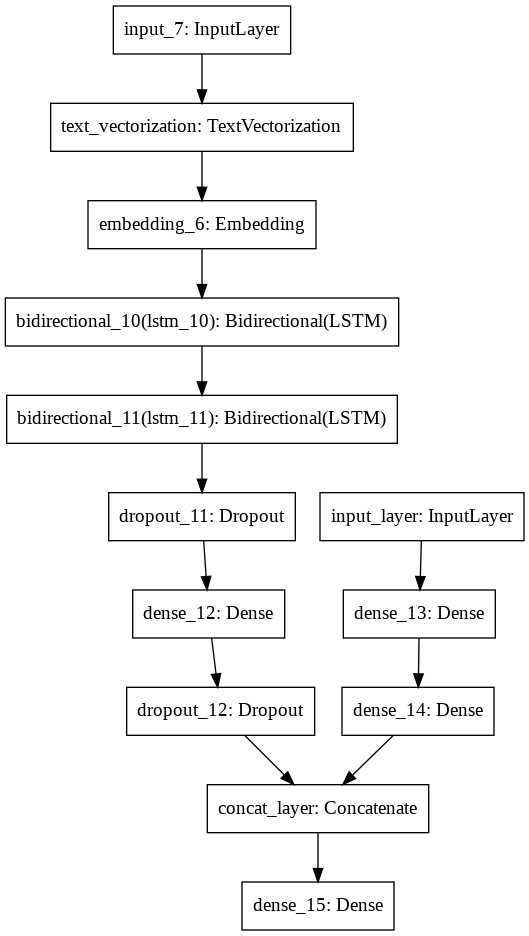

In [65]:
from tensorflow.keras.utils import plot_model
plot_model(sent_lstm_model)

In [66]:
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

sent_lstm_model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=METRICS)

In [67]:
sent_lstm_model.fit(train_combined_dataset_repeat, 
                    epochs=10,
                    steps_per_epoch=int(0.2*len(train_combined_dataset)),
                    validation_data=val_combined_dataset_repeat,
                    validation_steps=int(0.2*len(val_combined_dataset)))

Epoch 1/10
1490/1490 [==============================] - 50s 30ms/step - loss: 0.5852 - accuracy: 0.6896 - precision: 0.6887 - recall: 0.8022 - val_loss: 0.5349 - val_accuracy: 0.7220 - val_precision: 0.7004 - val_recall: 0.8664
Epoch 2/10
1490/1490 [==============================] - 43s 29ms/step - loss: 0.5518 - accuracy: 0.7167 - precision: 0.7094 - recall: 0.8252 - val_loss: 0.5107 - val_accuracy: 0.7450 - val_precision: 0.7532 - val_recall: 0.7998
Epoch 3/10
1490/1490 [==============================] - 42s 28ms/step - loss: 0.5401 - accuracy: 0.7255 - precision: 0.7157 - recall: 0.8372 - val_loss: 0.4987 - val_accuracy: 0.7467 - val_precision: 0.7512 - val_recall: 0.8084
Epoch 4/10
1490/1490 [==============================] - 41s 28ms/step - loss: 0.5324 - accuracy: 0.7295 - precision: 0.7180 - recall: 0.8386 - val_loss: 0.4966 - val_accuracy: 0.7553 - val_precision: 0.7649 - val_recall: 0.8032
Epoch 5/10
1490/1490 [==============================] - 42s 28ms/step - loss: 0.5269 - a

In [68]:
hybrid_model_preds = get_preds(sent_lstm_model, val_combined_dataset)
hybrid_results = calc_metrics(val_labels, hybrid_model_preds)
hybrid_results

{'accuracy': 0.7686791099703701,
 'f1': 0.8043294327996041,
 'precision': 0.7545225829639391,
 'recall': 0.8611766314566027}

In [73]:
model_lstm_no_pretrain.layers[2]

True

# Compare Results

In [77]:
compare_results = pd.DataFrame({'baseline':baseline_metrics,
                                'lstm_no_pretraining':model_lstm_no_pretrain_metrics,
                                'lstm_prefinetune':metrics_conv_prefinetune,
                                'lstm_finetine':metrics_lstm_finetune,
                                'conv1D_prefinetune':metrics_conv_prefinetune,
                                'conv1D_fintuene':metrics_conv_post_finetine})
compare_results = compare_results.T
compare_results

,accuracy,precision,recall,f1
baseline,0.729632,0.712146,0.856459,0.777664
lstm_no_pretraining,0.779682,0.778351,0.840187,0.808088
lstm_prefinetune,0.754166,0.719622,0.908796,0.803221
lstm_finetine,0.777474,0.768497,0.854271,0.809118
conv1D_prefinetune,0.754166,0.719622,0.908796,0.803221
conv1D_fintuene,0.759130,0.761979,0.819779,0.789823


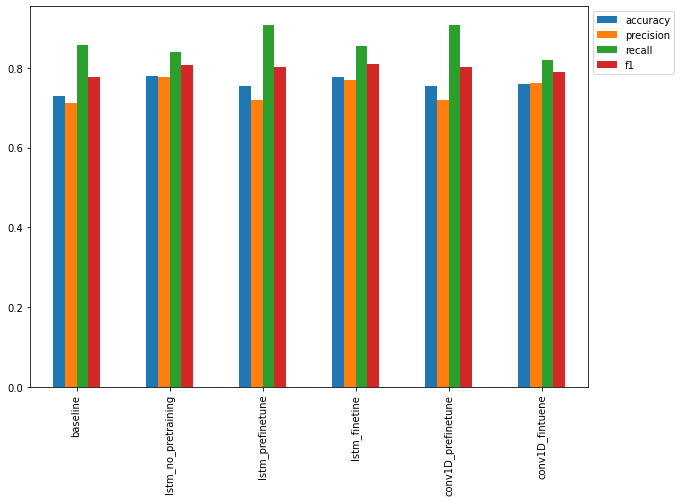

In [78]:
compare_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


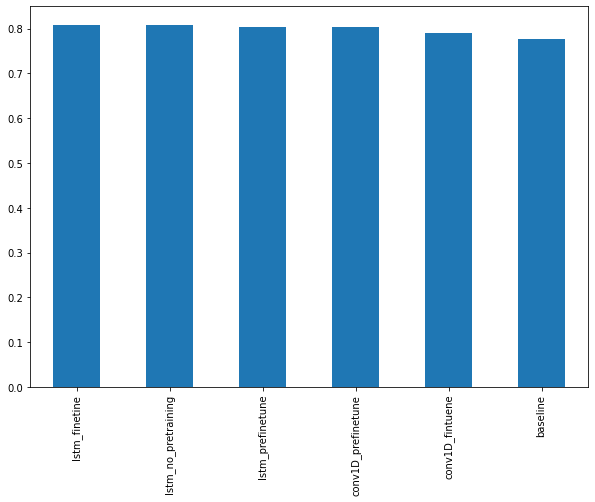

In [79]:
compare_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


In [81]:
compare_results.sort_values("f1", ascending=False)[["f1"]]

,f1
lstm_finetine,0.809118
lstm_no_pretraining,0.808088
lstm_prefinetune,0.803221
conv1D_prefinetune,0.803221
conv1D_fintuene,0.789823
baseline,0.777664
